In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall opencv-python-headless==4.5.5.62

In [3]:
!pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 135 kB/s 


In [4]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 38.1 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
#Dataset for read only
import os
from xml.etree import ElementTree as et
#Data processing and data visualization with bounding boxes
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#Global used to return all file paths with speicifc pattern
import glob
#Linear Algebra
import numpy as np # linear algebra
#Parsing HTML and XML Documents (We use the XML docs)
from bs4 import BeautifulSoup
#Model
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2

print('DONE')

DONE


In [6]:
import time

###Make a dataset and dataloader

In [7]:
import zipfile
from google.colab import drive
zip_ref = zipfile.ZipFile("/content/input.zip", 'r')
zip_ref.extractall("content/Data")
zip_ref.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
DONE
dict_keys(['Visible change without cavitation', 'Visible change with cavitation', 'Visible change with microcavitation']) 
 dict_values([99, 29, 88])


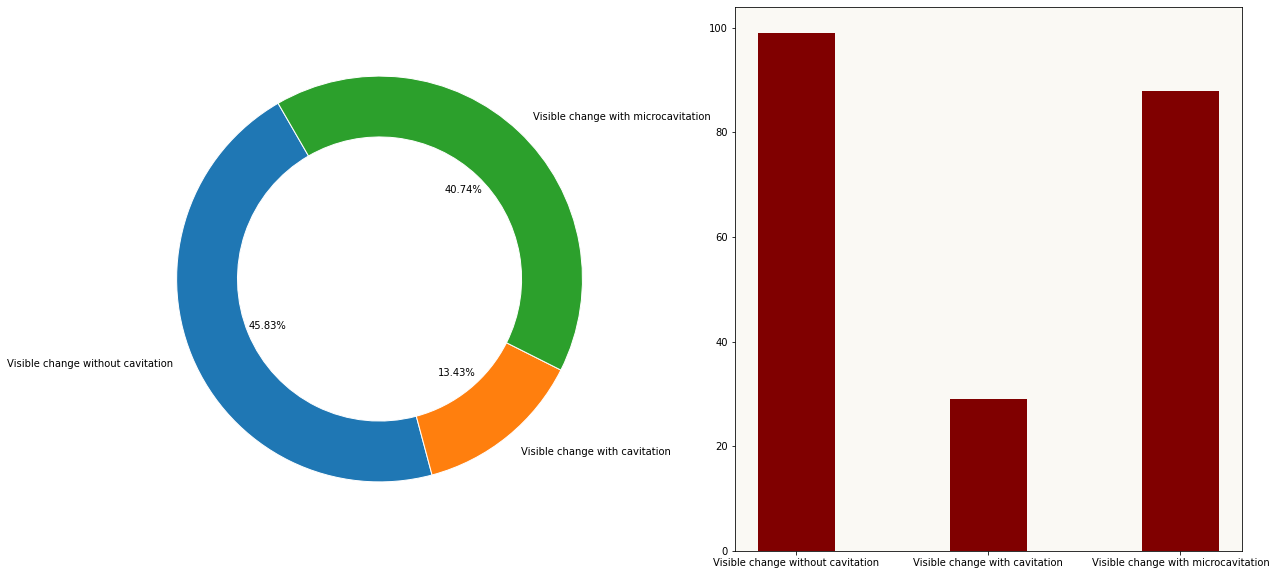

In [8]:
import seaborn as sns
from collections import Counter
import sys
import torch.optim as optim
!pip install xmltodict
import xmltodict
print('DONE')
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/content/Data/input/'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)
            
path_annotations="/content/Data/input/ToothDecayDetection/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(20,10))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

In [9]:
images_dir = '/content/Data/input/ToothDecayDetection/images/'
annotations_dir = '/content/Data/input/ToothDecayDetection/annotations/'

In [10]:
class ToothDecayDataset(torch.utils.data.Dataset):
    
    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # Sorting images and checking extension filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # Classes divided into 4 with background labeled 0
        self.classes = [_, 'Visible change without cavitation', 'Visible change with microcavitation', 'Visible change with cavitation']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # Reading the images    
        img = cv2.imread(image_path)
        
        # Converting size and color
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        
        # Image Normalization归一化
        img_res /= 255.0
        
        # Annotate files
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # CV2 shaping height and width sizes
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Bounding box coordinates for XML files
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # Corrected for image size given
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            
            sample = self.transforms(image = img_res, 
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [11]:
# Checking dataset
dataset = ToothDecayDataset(images_dir, annotations_dir, 480, 480)
print('length of dataset = ', len(dataset), '\n')

# Testing image shape
img, target = dataset[0]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  164 

Image shape =  (480, 480, 3) 
 Target -  {'boxes': tensor([[147.0732, 314.2212, 315.3658, 480.0000],
        [171.2195, 187.0880, 262.3171, 277.0203],
        [ 16.0976, 143.3860, 146.3415, 271.9639]]), 'labels': tensor([2, 2, 1]), 'area': tensor([27899.3555,  8192.6123, 16746.4863]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([0])}


In [12]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1) 
    #Use this function to determine the position of the plot, where the arguments represent the number of rows and columns of the subplot, respectively，一一个figure图像和子图a的array列表。
    fig.set_size_inches(5,5) 
    
    a.imshow(img, cmap='gray') 
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Drawing the bounding box on images
        a.add_patch(rect)
    plt.show()

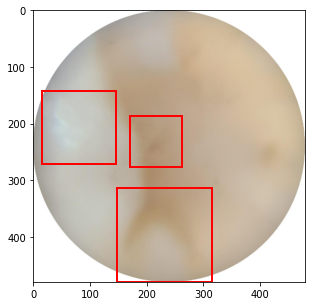

Target: {'boxes': tensor([[147.0732, 314.2212, 315.3658, 480.0000],
        [171.2195, 187.0880, 262.3171, 277.0203],
        [ 16.0976, 143.3860, 146.3415, 271.9639]]), 'labels': tensor([2, 2, 1]), 'area': tensor([27899.3555,  8192.6123, 16746.4863]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([0])}


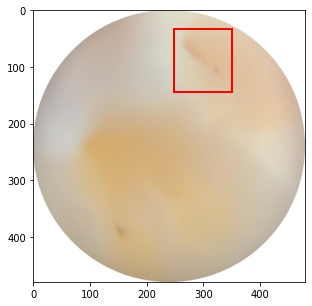

Target: {'boxes': tensor([[247.6868,  32.9375, 351.2029, 145.0732]]), 'labels': tensor([2]), 'area': tensor([11607.8408]), 'iscrowd': tensor([0]), 'image_id': tensor([50])}


In [13]:
# Plotting bounding box on the images
img, target = dataset[0] 
plot_img_bbox(img, target)
print('Target:',target)
img, target = dataset[50] 
plot_img_bbox(img, target)
print('Target:',target)

In [14]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.OneOf([
                                A.MotionBlur(p=0.2),  
                                A.MedianBlur(blur_limit=3, p=0.2),    
                                A.Blur(blur_limit=3, p=0.2),   
                            ], p=0.4),  
                            A.RandomBrightnessContrast(p=0.1), 
                            A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.2),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
# use our dataset and defined transformations
dataset = ToothDecayDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = ToothDecayDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# train test split
test_split = 0.1
tsize = int(len(dataset)*test_split)
print('len_dataset_all=',len(dataset))
print('test_size =',tsize)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize]) 
print('len_dataset_train=',len(dataset))
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:]) 
print('len_dataset_test=',len(dataset_test))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

print ('len_data_loader=',len(data_loader))
print ('len_data_loader_test=',len(data_loader_test))

len_dataset_all= 164
test_size = 16
len_dataset_train= 148
len_dataset_test= 16
len_data_loader= 37
len_data_loader_test= 4


In [19]:
def get_model_instance_segmentation(num_classes):
    #Load the pretrained model
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    #Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features 
    #Replace the pre-trained head with a new head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [20]:
def IOU(box1, box2):
    # Compute coordinates of intersection
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])

    # calculate area of intersection rectangle
    inter_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1) # FIXME why plus one?
 
    # calculate boxes areas
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
 
    # compute IoU
    iou = inter_area / float(area1 + area2 - inter_area)
    assert iou >= 0
    return iou

In [21]:
def compute_AP(ground_truth, predictions, iou_thresh, n_classes=4):
    # Initialize lists
    APs = []
    class_gt = []
    class_predictions = []

    # AP is computed for each class
    for c in range(n_classes):
        # Find gt and predictions of the class
        for gt in ground_truth:
            if gt[4] == c:
                class_gt.append(gt)
        for predict in predictions:
            if predict[4] == c:
                class_predictions.append(predict)

        # Create dict with array of zeros for bb in each image
        gt_amount_bb = Counter([gt[1] for gt in class_gt])
        for key, val in gt_amount_bb.items():
            gt_amount_bb[key] = np.zeros(val)

        # Sort class predictions by their score
        class_predictions = sorted(class_predictions, key=lambda x: x[5], reverse=True)

        # Create arrays for Positives (True and False)
        TP = np.zeros(len(class_predictions))
        FP = np.zeros(len(class_predictions))
        # Number of true boxes
        truth = len(class_gt)

        # Initializing aux variables
        epsilon = 1e-6

        # Iterate over predictions in each image and compare with ground truth
        for predict_idx, prediction in enumerate(class_predictions):
            # Filter prediction image ground truths
            image_gt = [obj for obj in class_gt if obj[1] == prediction[1]]

            # Initializing aux variables
            best_iou = -1
            best_gt_iou_idx = -1

            # Iterate through image ground truths and calculate IoUs
            for gt_idx, gt in enumerate(image_gt):
                iou = IOU(prediction[3], gt[3])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_iou_idx = gt_idx

            # If the best IoU is greater that thresh than an TP prediction has been found
            if best_iou > iou_thresh and best_gt_iou_idx > -1:
                # Check if gt box was already covered
                if  gt_amount_bb[prediction[1]][best_gt_iou_idx] == 0:
                    gt_amount_bb[prediction[1]][best_gt_iou_idx] = 1  # set as covered
                    TP[predict_idx] = 1  # Count as true positive
                else:
                    FP[predict_idx] = 1
            else:
                FP[predict_idx] = 1

        # Calculate recall and precision
        TP_cumsum = np.cumsum(TP)
        FP_cumsum = np.cumsum(FP)
        recall = np.append([0], TP_cumsum / (truth + epsilon))
        precision = np.append([1], np.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon)))

        # Calculate the area precision/recall and add to list
        AP = np.trapz(precision, recall)
        APs.append(AP)

    #print('APs =',APs)
    return sum(APs)/3  # average of class precisions

In [22]:
def compute_mAP(ground_truth, predictions, n_classes):
    # return mAP
    iou_thresh = 0.5
    mAP = compute_AP(ground_truth, predictions, iou_thresh, n_classes)
    return mAP

In [23]:
def evaluate(model, data_loader, device, sequences=1):
    # Set evaluation mode flag
    model.eval()
    # Create list with all object detection -> [set, frame, obj, [xmin,ymin,xmax,ymax], label, score]
    ground_truth = []
    predictions = []

    # Gather all targets and outputs on test set
    for image, targets in data_loader:
        image = [img.to(device) for img in image]
        outputs = model(image)
        for idx in range(len(outputs)):
            outputs[idx] = apply_nms(outputs[idx], iou_thresh=0.3)

        # create list for targets and outputs to pass to compute_mAP()
        # lists have the following structure:  [sequence, frame, obj_idx, [xmin, ymin, xmax, ymax], label, score]
        for s in range(sequences):
            obj_gt = 0
            obj_target = 0
            for out, target in zip(outputs, targets):

                for i in range(len(target['boxes'])):
                    ground_truth.append([s, target['image_id'].detach().cpu().numpy()[0], obj_target,
                                         target['boxes'].detach().cpu().numpy()[i],
                                         target['labels'].detach().cpu().numpy()[i], 1])
                    obj_target += 1

                for j in range(len(out['boxes'])):
                    predictions.append([s, target['image_id'].detach().cpu().numpy()[0], obj_gt,
                                        out['boxes'].detach().cpu().numpy()[j],
                                        out['labels'].detach().cpu().numpy()[j],
                                        out['scores'].detach().cpu().numpy()[j]])
                    obj_gt += 1

    mAP = compute_mAP(ground_truth, predictions, n_classes=4)

    return mAP

In [24]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
   
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')


In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4  
model = get_model_instance_segmentation(num_classes)  # load model
epochs = 80
b = 0.1
# Load the model to the specified device
model.to(device)
# Set optimizer parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,  #model optimizer
                                               #step_size=3,  #Learning rate update step size (note that it is updated every step_size epoch)

                                               #gamma=0.1)  #Decay rate (default 0.1, that is, lr becomes lr*gamma after every step_size epoch
len_dataloader = len(data_loader)
len_dataloader_test = len(data_loader_test)
epoch_loss_min = 1000
mAP_max = 0
E = []
L = []
LT = []
M = []
MT = []
loss_classifier_mean = []
loss_classifier_mean_test = []
loss_box_reg_mean = []
loss_box_reg_mean_test = []
loss_objectness_mean = []
loss_objectness_mean_test = []
loss_rpn_box_reg_mean = []
loss_rpn_box_reg_mean_test = []
for epoch in range(epochs):
    print('training:', epoch + 1, 'of', epochs)
    model.train()
    epoch_loss = 0
    epoch_loss_test = 0
    loss_classifier = []
    loss_box_reg = []
    loss_objectness = []
    loss_rpn_box_reg = []
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)  # Convert data to list
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)

        loss_classifier.append(loss_dict['loss_classifier'].detach().cpu().numpy())
        loss_box_reg.append(loss_dict['loss_box_reg'].detach().cpu().numpy())
        loss_objectness.append(loss_dict['loss_objectness'].detach().cpu().numpy())
        loss_rpn_box_reg.append(loss_dict['loss_rpn_box_reg'].detach().cpu().numpy())

        losses = sum(loss for loss in loss_dict.values())  # 求和
        flood = abs(losses-b)

        optimizer.zero_grad()  #It means to set the gradient to zero, that is, to change the derivative of loss with respect to weight to 0
        flood.backward()  # Backpropagation, calculate the current gradient
        optimizer.step()  # Update network parameters based on gradients
        epoch_loss += losses.item()  #Convert a zero-dimensional tensor (losses) to float
    epoch_loss /= len_dataloader
    lc = np.mean(loss_classifier)
    loss_classifier_mean.append(lc)
    lbr = np.mean(loss_box_reg)
    loss_box_reg_mean.append(lbr)
    lo = np.mean(loss_objectness)
    loss_objectness_mean.append(lo)
    lrbr = np.mean(loss_rpn_box_reg)
    loss_rpn_box_reg_mean.append(lrbr)

    with torch.no_grad():
        loss_classifier = []
        loss_box_reg = []
        loss_objectness = []
        loss_rpn_box_reg = []
        for imgs, annotations in data_loader_test:
            imgs = list(img.to(device) for img in imgs)  # Convert data to list
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)

            loss_classifier.append(loss_dict['loss_classifier'].detach().cpu().numpy())
            loss_box_reg.append(loss_dict['loss_box_reg'].detach().cpu().numpy())
            loss_objectness.append(loss_dict['loss_objectness'].detach().cpu().numpy())
            loss_rpn_box_reg.append(loss_dict['loss_rpn_box_reg'].detach().cpu().numpy())

            losses = sum(loss for loss in loss_dict.values())
            epoch_loss_test += losses.item()  #Convert a zero-dimensional tensor (losses) to float
        epoch_loss_test /= len_dataloader_test
        lct = np.mean(loss_classifier)
        loss_classifier_mean_test.append(lct)
        lbrt = np.mean(loss_box_reg)
        loss_box_reg_mean_test.append(lbrt)
        lot = np.mean(loss_objectness)
        loss_objectness_mean_test.append(lot)
        lrbrt = np.mean(loss_rpn_box_reg)
        loss_rpn_box_reg_mean_test.append(lrbrt)

    E.append(epoch + 1)
    L.append(epoch_loss)
    LT.append(epoch_loss_test)
    model.eval()
    mAP = evaluate(model, data_loader, device=device)
    mAP_test = evaluate(model, data_loader_test, device=device)
    M.append(mAP)
    MT.append(mAP_test)
    print('Epoch=', epoch + 1)
    print('train_loss=', epoch_loss)
    print('test_loss=', epoch_loss_test)
    print('mAP_train =', mAP, ';mAP_test =', mAP_test)
    if epoch_loss < epoch_loss_min:
        epoch_loss_min = epoch_loss
        print('Loss drops, save this model, current Epoch for', epoch + 1, 'train_loss=', epoch_loss)
        print('Saving......')
        torch.save(model.state_dict(), 'model_loss_best.pt')
        print('Succesfully saved!')
    if mAP_test > mAP_max:
        mAP_max = mAP_test
        print('Accuracy improvement, save this model, current Epoch for', epoch + 1, 'mAP_test=', mAP_test)
        print('Saving......')
        torch.save(model.state_dict(), 'model_mAP_best.pt')
        print('Succesfully saved！')

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

training: 1 of 80
Epoch= 1
train_loss= 1.6001998894923442
test_loss= 1.4046529531478882
mAP_train = 0.3770003684693178 ;mAP_test = 0.4210065170902168
Loss drops, save this model, current Epoch for 1 train_loss= 1.6001998894923442
Saving......
Succesfully saved!
Accuracy improvement, save this model, current Epoch for 1 mAP_test= 0.4210065170902168
Saving......
Succesfully saved！
training: 2 of 80
Epoch= 2
train_loss= 1.3360030328905261
test_loss= 1.4114075899124146
mAP_train = 0.5807944262659839 ;mAP_test = 0.5247549082804909
Loss drops, save this model, current Epoch for 2 train_loss= 1.3360030328905261
Saving......
Succesfully saved!
Accuracy improvement, save this model, current Epoch for 2 mAP_test= 0.5247549082804909
Saving......
Succesfully saved！
training: 3 of 80
Epoch= 3
train_loss= 1.2745878938082102
test_loss= 1.3927043974399567
mAP_train = 0.6357827596516303 ;mAP_test = 0.6370360935127183
Loss drops, save this model, current Epoch for 3 train_loss= 1.2745878938082102
Saving

In [56]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

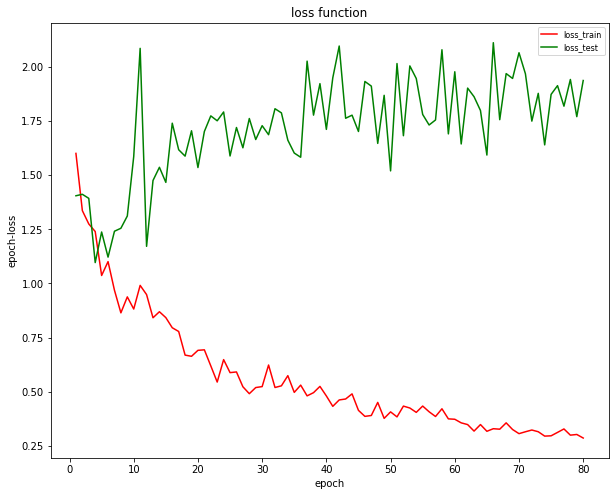

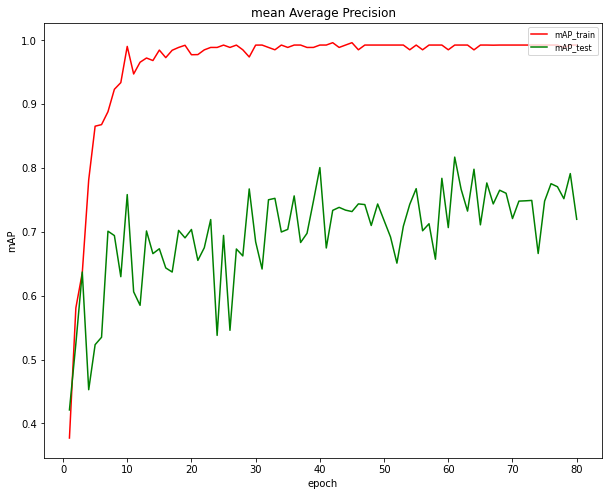

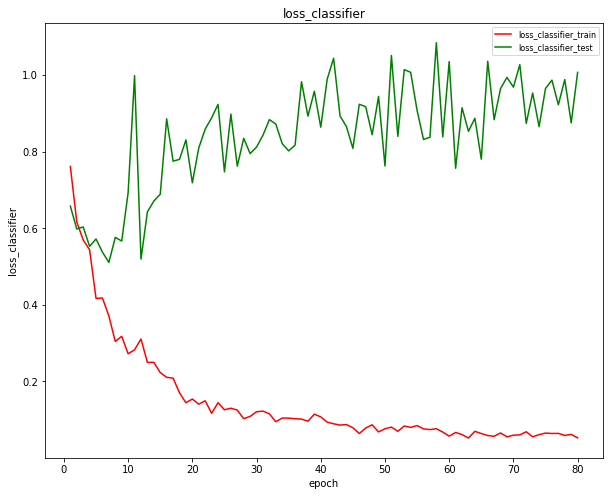

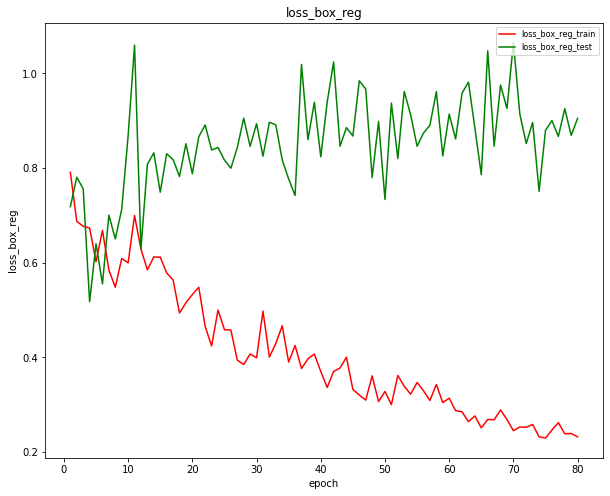

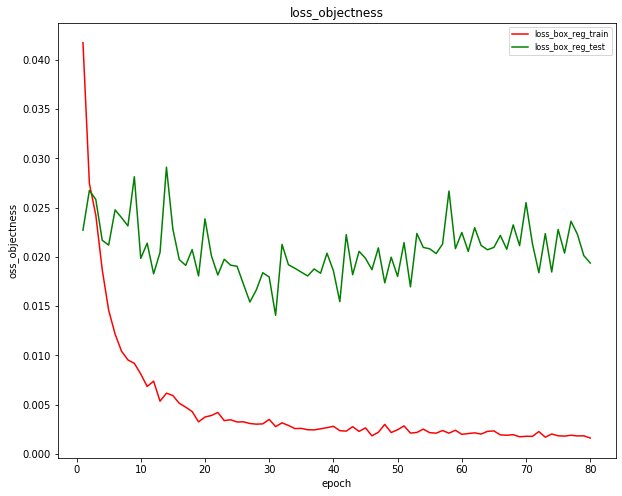

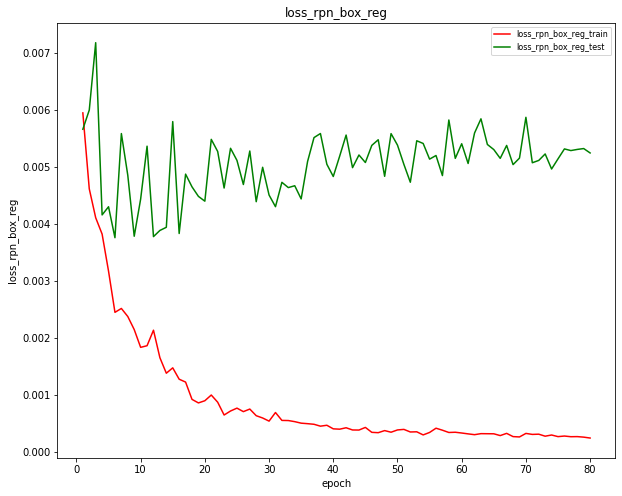

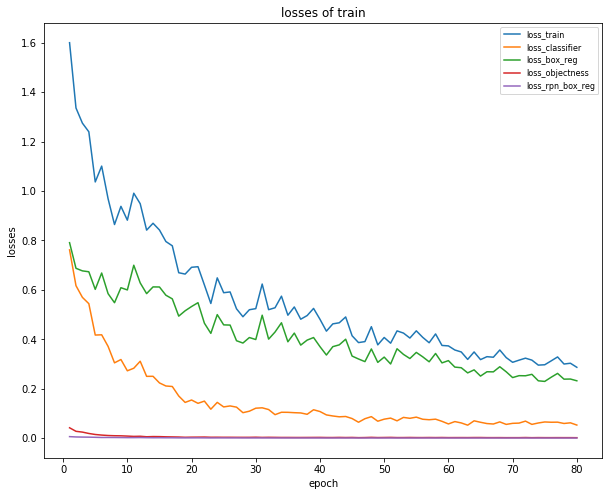

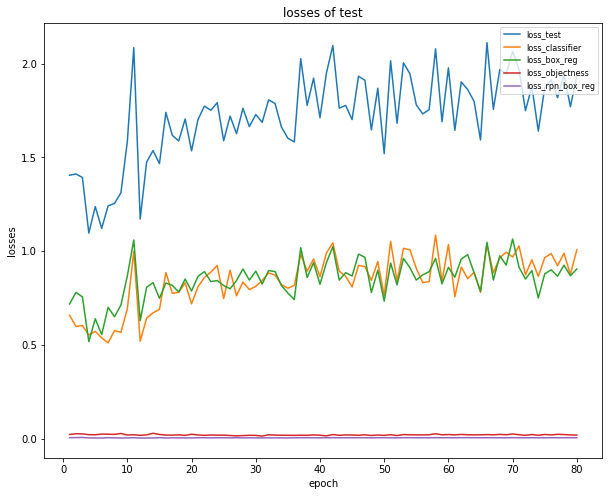

In [57]:
plt.title('loss function')
plt.xlabel('epoch')
plt.ylabel('epoch-loss')
plt.plot(E, L, color='red')
plt.plot(E, LT, color='green')
plt.legend(labels=["loss_train","loss_test"],loc="upper right",fontsize=8)
plt.show()



plt.title('mean Average Precision')
plt.xlabel('epoch')
plt.ylabel('mAP')
plt.plot(E, M, color='red')
plt.plot(E, MT, color='green')
plt.legend(labels=["mAP_train","mAP_test"],loc="upper right",fontsize=8)
plt.show()

plt.title('loss_classifier')
plt.xlabel('epoch')
plt.ylabel('loss_classifier')
plt.plot(E, loss_classifier_mean, color='red')
plt.plot(E, loss_classifier_mean_test, color='green')
plt.legend(labels=["loss_classifier_train","loss_classifier_test"],loc="upper right",fontsize=8)
plt.show()

plt.title('loss_box_reg')
plt.xlabel('epoch')
plt.ylabel('loss_box_reg')
plt.plot(E, loss_box_reg_mean, color='red')
plt.plot(E, loss_box_reg_mean_test, color='green')
plt.legend(labels=["loss_box_reg_train","loss_box_reg_test"],loc="upper right",fontsize=8)
plt.show()

plt.title('loss_objectness')
plt.xlabel('epoch')
plt.ylabel('oss_objectness')
plt.plot(E, loss_objectness_mean, color='red')
plt.plot(E, loss_objectness_mean_test, color='green')
plt.legend(labels=["loss_box_reg_train","loss_box_reg_test"],loc="upper right",fontsize=8)
plt.show()


plt.title('loss_rpn_box_reg')
plt.xlabel('epoch')
plt.ylabel('loss_rpn_box_reg')
plt.plot(E, loss_rpn_box_reg_mean, color='red')
plt.plot(E, loss_rpn_box_reg_mean_test, color='green')
plt.legend(labels=["loss_rpn_box_reg_train","loss_rpn_box_reg_test"],loc="upper right",fontsize=8)
plt.show()

plt.title('losses of train')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.plot(E, L)
plt.plot(E, loss_classifier_mean, label='loss_classifier')
plt.plot(E, loss_box_reg_mean, label='loss_box_reg')
plt.plot(E, loss_objectness_mean, label='loss_objectness')
plt.plot(E, loss_rpn_box_reg_mean, label='loss_rpn_box_reg')
plt.legend(labels=["loss_train","loss_classifier","loss_box_reg","loss_objectness","loss_rpn_box_reg"],loc="upper right",fontsize=8)
plt.show()

plt.title('losses of test')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.plot(E, LT)
plt.plot(E, loss_classifier_mean_test, label='loss_classifier')
plt.plot(E, loss_box_reg_mean_test, label='loss_box_reg')
plt.plot(E, loss_objectness_mean_test, label='loss_objectness')
plt.plot(E, loss_rpn_box_reg_mean_test, label='loss_rpn_box_reg')
plt.legend(labels=["loss_test","loss_classifier","loss_box_reg","loss_objectness","loss_rpn_box_reg"],loc="upper right",fontsize=8)
plt.show()

###Evaluation Result

In [29]:
PATH='/content/model_mAP_best.pt'

In [30]:
device = torch.device('cpu')
model=get_model_instance_segmentation(4)

model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [31]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 184393, done.
remote: Counting objects: 100% (4492/4492), done.
remote: Compressing objects: 100% (412/412), done.
remote: Total 184393 (delta 4093), reused 4427 (delta 4068), pack-reused 179901
Receiving objects: 100% (184393/184393), 363.67 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (165392/165392), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [34]:
print('Evauation on test data mAP',evaluate(model, data_loader_test , device=device))

Evauation on test data mAP 0.8170431987437935


IsADirectoryError: ignored

#Inference

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12351, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 12351 (delta 77), reused 89 (delta 46), pack-reused 12218
Receiving objects: 100% (12351/12351), 12.35 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (8446/8446), done.


In [ ]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 8.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:

import cv2

In [ ]:
with open('new_train_yaml', 'w+') as file:
    file.write(
        """
        # parameters
        nc: 3  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

In [28]:
with open('new_data_yaml', 'w+') as file:
    file.write(
        """
        train: /content/drive/MyDrive/YOLOV5_Faisal_1/images/train
        val: /content/drive/MyDrive/YOLOV5_Faisal_1/images/valid

        nc: 3
        names: ['Visible change without cavitation','Visible change with microcavitation','Visible change with cavitation'
]
        """
    )

In [ ]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 7.6 MB/s 


In [ ]:
!export PYTHONPATH="$PWD" && python models/export.py --weights /content/model_mAP_best.pt --img 640 --batch 1

python3: can't open file 'models/export.py': [Errno 2] No such file or directory


In [ ]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5','custom',yolov5s',force_reload=True)  # or yolov5m, yolov5l, yolov5x, etc.
# model = torch.hub.load('ultralytics/yolov5', 'custom', 'path/to/best.pt')  # custom trained model

# Images
im = '/content/1.jpg'  # or file, Path, URL, PIL, OpenCV, numpy, list

# Inference
results = model(im)

# Results
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

results.xyxy[0]  # im predictions (tensor)
results.pandas().xyxy[0] 

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-8-1 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 1/1: 1375x1432 (no detections)
Speed: 55.4ms pre-process, 22.1ms inference, 0.9ms NMS per image at shape (1, 3, 640, 640)


,xmin,ymin,xmax,ymax,confidence,class,name


In [ ]:
!python /content/yolov5/train.py --img 416 --batch 64 --epochs 2 --data /content/new_data_yaml --cfg /content/new_train_yaml  --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=/content/new_train_yaml, data=/content/new_data_yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=64, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.1-325-g3e85863 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0

##Finish

In [ ]:
PATH='/content/model_mAP_best.pt'

In [ ]:
device = torch.device('cpu')
model=get_model_instance_segmentation(4)

model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
!python /content/yolov5/detect.py --source testImage1.jpg --weights /content/model_mAP_best.pt --img 480 --conf 0.5 --save-txt

detect: weights=['PATH'], source=testImage1.jpg, data=yolov5/data/coco128.yaml, imgsz=[480, 480], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-325-g3e85863 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 257, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 252, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/detect.py", line 93, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
  File "/c

In [ ]:
PATH='/content/model_mAP_best.pt'

In [ ]:
device = torch.device('cpu')
model=get_model_instance_segmentation(4)

model.load_state_dict(torch.load(PATH, map_location=device))



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
{1:'Visible change without cavitation', 2:'Visible change with microcavitation', 3:'Visible change with cavitation'}

In [58]:
# pick one image from the test set
img, target = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  6
real #boxes:  2


EXPECTED OUTPUT


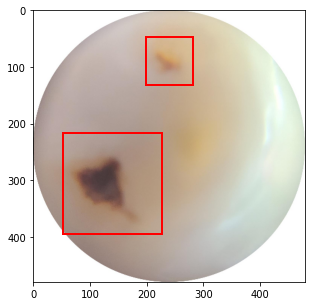

In [59]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


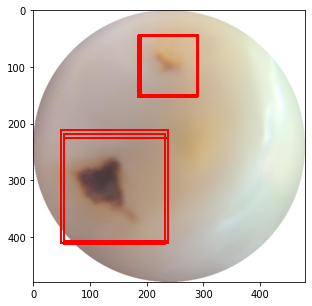

In [60]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


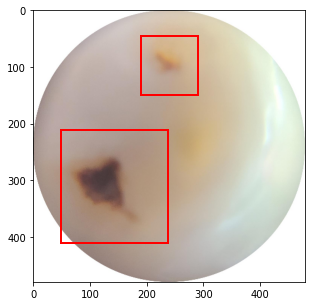

In [61]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [98]:
def plot_image(img_tensor, annotation,predict=True):
    
    fig,ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    img = img_tensor.detach().squeeze(-1).cpu().data
    mask_dic = {1:'Visible change without cavitation', 2:'Visible change with microcavitation', 3:'Visible change with cavitation'}

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for i,box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        label = mask_dic[int(annotation['labels'][i].data)]
        if predict:
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
        else:
            score=''
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
    plt.show()

In [65]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [66]:
model.eval()
preds = model(imgs)

Prediction


RuntimeError: ignored

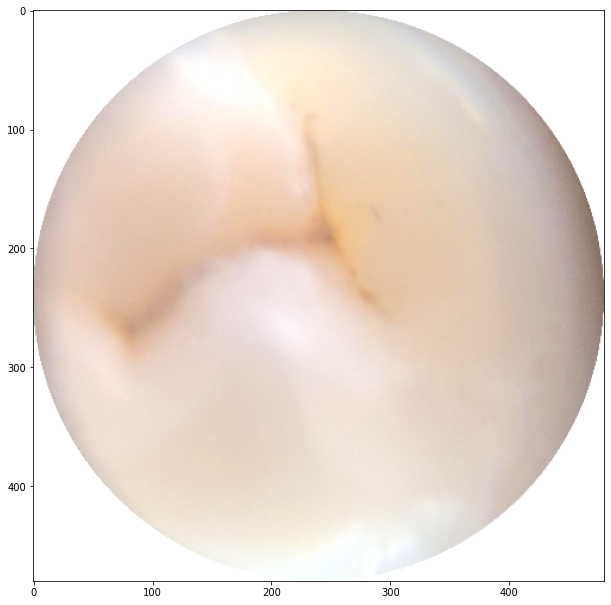

In [97]:
nms_prediction = apply_nms(preds[1], iou_thresh=0.2)
print("Prediction")
#output.detach().squeeze(-1)
plot_image(imgs[1], nms_prediction)
print("Target")
plot_image(imgs[1].to('cpu'), annotations[1],False)